<a href="https://colab.research.google.com/github/srv-sh/FakeNewsDetection/blob/main/FakeNewsDetection(BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "souravsaha058" # জেসন ফাইল থেকে আইডিটা নিয়ে আসুন
os.environ['KAGGLE_KEY'] = "be092deadd788c30f54a1e93e250d3ae" # আপনার ক্যাগল কী


In [2]:
# install ktrain
!pip install ktrain

     |████████████████████████████████| 25.3MB 125kB/s 
     |████████████████████████████████| 6.8MB 56.8MB/s 
     |████████████████████████████████| 983kB 47.2MB/s 
     |████████████████████████████████| 266kB 54.5MB/s 
     |████████████████████████████████| 1.9MB 42.4MB/s 
     |████████████████████████████████| 1.2MB 44.0MB/s 
     |████████████████████████████████| 471kB 53.5MB/s 
     |████████████████████████████████| 870kB 47.1MB/s 
     |████████████████████████████████| 3.3MB 44.6MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=1246c906a6acc51bac31be8efaf1ba51397d5be25557f9c9619a94bba070ff69
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=5067cd647e3045ece4710039346acff51a66b42c095fb138bf226f2999ccc2ea
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [3]:
#Import all the librery
import tensorflow as tf
import pandas as pd
import numpy as np
import ktrain

from ktrain import text



In [4]:
# get the data from keras
!kaggle datasets files cryptexcode/banfakenews


name                      size  creationDate         
-----------------------  -----  -------------------  
LabeledFake-1K.csv         6MB  2021-03-10 05:41:02  
Authentic-48K.csv        233MB  2021-03-10 05:41:02  
LabeledAuthentic-7K.csv   33MB  2021-03-10 05:41:02  
Fake-1K.csv                6MB  2021-03-10 05:41:02  


In [5]:
#download the data from keras
!kaggle datasets download -d cryptexcode/banfakenews

 93% 57.0M/61.5M [00:00<00:00, 63.8MB/s]
100% 61.5M/61.5M [00:00<00:00, 70.4MB/s]


In [6]:
#unZip the data
!unzip banfakenews.zip


Archive:  banfakenews.zip
  inflating: Authentic-48K.csv       
  inflating: Fake-1K.csv             
  inflating: LabeledAuthentic-7K.csv  
  inflating: LabeledFake-1K.csv      


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#Import data
import pandas as pd 
df1 = pd.read_csv("/content/Authentic-48K.csv")
df2 = pd.read_csv("/content/Fake-1K.csv")
df3 = pd.read_csv("/content/LabeledAuthentic-7K.csv")
df4 = pd.read_csv("/content/LabeledFake-1K.csv")
df5 = pd.read_csv("/content/drive/MyDrive/data/Fake1k.csv") # this data is from another dataset



In [10]:
#concatinate all the data and store into one data frame
df = pd.concat([df1, df2, df3,df4])
print(df.shape)
df.head()


(58478, 10)


,articleID,domain,date,category,headline,content,label,source,relation,F-type
0,1,jagonews24.com,2018-09-19 17:48:18,Education,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,1.0,NaN,NaN,NaN
1,2,jagonews24.com,2018-09-19 17:48:19,National,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,1.0,NaN,NaN,NaN
2,3,jagonews24.com,2018-09-19 17:48:20,National,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,1.0,NaN,NaN,NaN
3,4,jagonews24.com,2018-09-19 17:48:21,Crime,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,1.0,NaN,NaN,NaN
4,5,jagonews24.com,2018-09-19 17:48:21,National,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,1.0,NaN,NaN,NaN


In [11]:
#Feature extraction
new_df = df.loc[: , ['content' , 'label']] 
new_df.shape

(58478, 2)

In [12]:
#Shuffle the dataset
import sklearn
new_df=sklearn.utils.shuffle(new_df)
new_df.tail()

,content,label
25284,আন্তর্জাতিক খ্যাতিসম্পন্ন অভিনেত্রী ববিতা চলচ্...,1.0
15370,নম্বর ঠিক রেখে অপারেটর বদল বা মোবাইল নম্বর পোর...,1.0
24359,গত সপ্তাহে বড় দরপতন হয় বাজারে। ফলে বিনিয়োগকারী...,1.0
28499,"মঙ্গলবার কমিশনের এক সংবাদ বিজ্ঞপ্তিতে বলা হয়, ...",1.0
140,এএফসি অনূর্ধ্ব-১৬ ফুটবলের বাছাই পর্বে বাংলাদেশ...,1.0


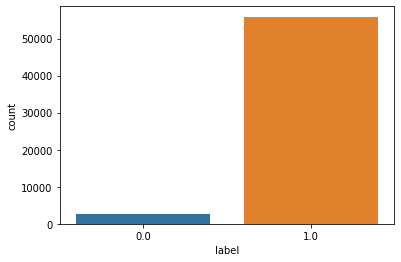

In [13]:
#Data visualization
tmp =  new_df['label'].value_counts().sort_index()
import seaborn as sb
sb.countplot(x='label' , data = new_df , order = tmp.index)

In [14]:
#Class weight Minority class will get higher priroty and majority class will get lower priroty
from sklearn.utils import class_weight
import numpy as np
class_weight = list(class_weight.compute_class_weight('balanced',np.unique(new_df['label']),new_df['label']))
weights={}
for index , weight in enumerate(class_weight):
  weights[index] = weight
weights

{0: 11.25442648190916, 1: 0.5232462419470294}

In [15]:
(X_train, y_train), (X_test , y_test) , preproc = text.texts_from_df(train_df= new_df,
                                                                     text_column = 'content',
                                                                     label_columns = 'label',
                                                                     maxlen=512,
                                                                     preprocess_mode = 'bert'
                                                                     )

/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:605: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')
/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:605: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


['not_label', 'label']
       not_label  label
19374        0.0    1.0
46633        0.0    1.0
43863        0.0    1.0
6367         0.0    1.0
4299         0.0    1.0
['not_label', 'label']
       not_label  label
36566        0.0    1.0
4055         0.0    1.0
33160        0.0    1.0
32005        0.0    1.0
7205         0.0    1.0
downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: bn


Is Multi-Label? False
preprocessing test...
language: bn


# Preprocessing

In [16]:
model = text.text_classifier(name='bert',
                             train_data = (X_train ,y_train),
                             preproc= preproc)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

Is Multi-Label? False
maxlen is 512
done.


# Find learner

In [17]:
learner = ktrain.get_learner(model = model , train_data=(X_train , y_train),
                             val_data = (X_test , y_test),
                             batch_size = 6)

# Finding best learning rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
8772/8772 [==============================] - 2475s 280ms/step - loss: 1.5354 - accuracy: 0.9444


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


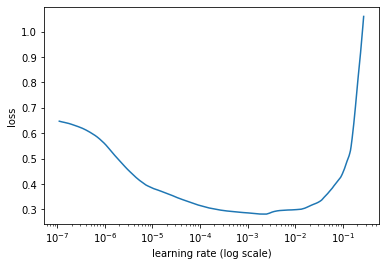

In [18]:
#findout best Learning rate
learner.lr_find()
learner.lr_plot()

# Training the model

In [20]:
learner.fit_onecycle(lr=10**-5, epochs=1, class_weight=weights)



begin training using onecycle policy with max lr of 1e-05...
8772/8772 [==============================] - 14253s 2s/step - loss: 0.3521 - accuracy: 0.8468 - val_loss: 0.1481 - val_accuracy: 0.9379


# Save the model

In [22]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('/content/drive/My Drive/bert')

# Import another dataset for Testing

In [68]:
df_test = pd.read_excel("/content/FinalData1.xls")

In [69]:
df_test[['Statement','Class']]

,Statement,Class
0,\n\nদেশে করোনাভাইরাসে আক্রান্ত হয়ে গত ২৪ ঘণ্টা...,Real
1,\n\nদ্বিতীয় বিশ্বযুদ্ধের পর থেকে বিশ্বের প্রভু...,Real
2,"\n\nবাড়ির পাশেই ভিক্টোরিয়া পার্ক, বিকেল হলেই স...",Real
3,\n\nবাইরে বেরোচ্ছি না বেশ কিছুদিন ধরে। বলা ভাল...,Real
4,\n\nসবার মতো লেখকেরাও এখন ঘরবন্দী। লেখকদের এই ...,Real
...,...,...
2536,\n\n\n\n\n\n\n \n\nএবার ইন্টারভিউর মাঝে পাদ দে...,Fake
2537,\n\n\n \n\nঅবশেষে বেরিয়ে এলো শফিক রেহমানের থল...,Fake
2538,\n\n\n\n\nএবার প্যান্টের ভেতর সাতটি সোনা সহ এক...,Fake
2539,\n\n\n\n\n\n\n\nএবার রাজধানীতে ঘটলো আরেকটি চাঞ...,Fake


In [71]:
content = df_test['Statement'].tolist()
labels = df_test['Class'].tolist()

In [77]:
import re
def rex(token):
    return re.sub("([A-Za-z0-9_:.]+|[\n]+|[\xa0]+|শেয়ার করুন,)","",token)

In [80]:
test =[rex(token) for token in content]


In [39]:
data = ['নম্বর নারী ও শিশু নির্যাতন দমন ট্রাইবুনাল আদালতের মহিলা বিচারক তানজিনা ইসমাঈল গৃহকর্মী নির্যাতনের মামলায় ক্রিকেটার শাহাদত হোসেন এবং তার স্ত্রী জেসমিন জাহানের কুনো দুষ খুজে না পেয়ে তাদেরকে বেকসুর খালাস দিয়েছেন। বিচার কার্য চলা কালে শাহাদতকে নিচের ছবি দেখালে তিনি বলেন, আমি তার গায়ে হাত তুলি নাই আল্লাহর কসম। শুনেন, আমি জাতীয় দলে খেলা ফাষ্ট বোলার। তাই সে যখন আমরার বাসায় কাজ করতে আসে, তখনই চুক্তি হইছিল, সে বাসায় আমার বোলিং পেকটিসের সময় হেলপ করবে। তারে তো বেটসমেন বানান যায় না, তাই সে হবে বেটসগার্ল। তো এক দিন তারে বোলিং করার সময় বাউন্সার দিছিলাম। সে ঠিক মতন খেলতে পারে নাই। বল গিয়া লাগে তার চুখের পাশে। এখন মাননীয় আদালত, আপনেই বলেন সে যদি হেলমেট না পইরা বেটিং করতে নামে, সেইটা আমার দুষ? আপনেই বলেন বোলারের বল বেটসমেনের গায়ে লাগার কারনে মামলা করা হইছে, এমন ইতিহাস দুনিয়ার কুথাও আছে? ইতি পুর্বে স্ত্রীকে মারধর ও যৌতুকের মামলায় কারাগারে থাকা কণ্ঠশিল্পী আরফিন রুমির জামিনের রায় দেওয়া এই মহিলা বিচারক তানজিনা ইসমাঈল তখন ফরিয়াদি পক্ষকে পশ্ন করেন, আসামী পক্ষ বলতেছে এক কথা, আর আপনারা দাবি করতেছেন শিশু মেয়েটারে মারা হইছে, গায়ে গাত তোলা হইছে। আপনাদের দাবির সপক্ষে কুনো ভিডু আছে?… নাই? কথা শেষ। মামলা ডিশমিস। শিশু নির্যাতন মামলায় মহিলা বিচারপতির রায়ে বেকসুর খালাস পাওয়া শাহাদত এর আগে এক সাক্ষাতকারে “মেয়েরা আপনাকে এত পছন্দ করে কেন?” এই প্রশ্নের উত্তরে বলছিলেন, “এটা আমি তো জানি না…হা হা হা। সবচেয়ে বড় কথা স্মার্টনেস। এটা অনেকের মধ্যেই নেই, আমার আছে। স্মার্টনেস জানেন তো? মানে পোশাক-আশাক, চালচলন। হাইটটা অনেক ইম্পর্টেন্ট। সবার স্মার্টনেস হাইটের জন্যই হয়। আমার মতো যাঁরা লম্বা, তাঁরা দেখবেন অনেক সময় গুজা (কুঁজো) হয়ে হাঁটে। এ রকম আমার মধ্যে নেই। স্মার্ট হওয়ার জন্য যা দরকার ওটা আমার মধ্যে আছে। প্লেয়াররা সবাই বলে দাড়ি থাকলে আমাকে আফ্রিদি আফ্রিদি লাগে। বিদেশে গেলেও দাড়ি থাকলে কেউ বলে না যে আমি বাংলাদেশি। বলে পাকিস্তানি। আমার হাইটটা অনেক ইম্পরটেন্ট। চেহারাও আল্লাহর রহমতে ভালো।',
        'নিজস্ব মতিবেদক সমাজ, সংসার ও সরকারের নীপীড়ন নীর্যাতনের বিরুদ্ধে প্রতিবাদের নতুন প্লাটফর্ম হিসেবে রাজনীতীর মঞ্চে প্রবেশ করেছে নতুন সংঘটন “ফিউরিয়াস ফখা ফ্রেটারনিটি” ওরফে “এফএফএফ”।মংগলবার সন্ধ্যায় প্রেস ক্লাবে আয়জিত এক সংবাদ সম্মেলনে এ সংঘটনের আত্ম প্রকাশের কথা তুলে ধরেন এফএফএফের প্রতিষ্ঠাতা আমীর ও বৃহত্তর জামায়াতের বিএনপি শাখার ভাঁড়মুক্ত মহানায়েব, জাতীয়তাবাদী শক্তির ‘কমপ্লান বয়’, লনডনে পলাতক চিকিতসাধীন আওলাদে আমীর বড় গুণ্ডে কতৃক ‘হাইড এন্ড সিক’ গালিতে ভুষিত ও ঈদুল কতলের টেলেন্ট হান্ট প্রতিযোগীতায় ‘ফ্লেয়ার এন্ড লাবলি’ খেতাবে সমাদৃত মির্জা বাড়ির বড় গৌরব আল্লামা মির্জা ফখরুল ইসলাম আগুনগীর ওরফে ফখা ইবনে চখা। কাদলেন ফখরুল সংবাদ সম্মেলনে আগুনগীর বলেন, আজ বাংলার রাজনীতীর আকাশে কাল মেঘের ঘনঘটা। কুথা হতে কি ঘটতেছে, বুঝা মুশকিল। চারিদিকে হয় জংগীর হামলা, নয় পুলিশের মামলা। তার উপরে যদি আপনার নাম ফখ দিয়া শুরু হয়, আপনার জীবন শেষ। হুহু করে কেদে উঠে ফখা ইবনে চখা বলেন, নিজের কথা ভাবি না। বিএনপি শাখার মহানায়েব আমি, সমস্ত অন্যায় মামলা হামলা ঝামলা আমার উপর দিয়া যাবে। উহার জন্যই আমায় মহানায়েব বানান হইছে। কিন্তু অন্য ফখরুলদের দুঃখে আমার রাত্রকালে ঘুম আসে না।\nঅশ্রু মুছে রাগারাগি করে মির্জা বাড়ির বড় গৌরব বলেন, কিছুদিন আগে বেরিষ্টার ফখরুলরে ব্রাদারফাকার সাকার মামলায় ট্রায়বুনালের রায় চুরির দায়ে দশ বছরের জেল দিয়া দিল। আপনারাই বলেন উহা কেমন বিচার? ট্রায়বুনালের রায় কেন, ঐশ্যরিয়া রায়রে চুরি করলেও ত দশ বছরের জেল দেওন উচিত না। কাঠগড়ায় তুলিয়া দুটু বকা দিয়া দিলেই ত চলত। কিংবা কানে হেডফুন বান্ধিয়া এস আই টুটুলের “আয় খোকা আয়” একশ বার শুনাইয়া দিলেই হইত। তা না করিয়া উহারে দিল হাজতে পাঠাইয়া। কেনে? কারন তার নাম ফখরুল। সে যদি বেরিষ্টার বদরুল, বেরিষ্টার সদরুল, বেরিষ্টার নজরুল, বেরিষ্টার ফজলুল, বেরিষ্টার কামরুল, বেরিষ্টার জামরুল ইত্যাদি হত, কুন সাজাই তার হত না। শুদু মাত্র ফখরুল হওয়ার কারনে তারে এইরুপ হেনস্তা করা হইল। কই, ব্রাদারফাকার সাকার বিবি আওলাদের ত কুন সাজা হল না। পাপ করল সবাই, জেল হইল ফখরুলের। ইয়ে কেয়সা অবিচার? আবারও কেদে ফেলে ফ্লেয়ার এন্ড লাবলি বলেন, তার পর দুই দিন পার হইয়া সারল না, বিশিষ্ঠ অভিনেতা ফখরুল হাসান বৈরাগীরে ফেসিবাদী বাকশালী সরকার গুমখুন করল। যদিও সে জেন্ত ফিরত আসিয়া বলতেছে যে সরকার উহাকে গুম করে নাই, খুনও করে নাই, সে গালফেন্ডের অত্যাচারের ঠেলায় আপন পুত্রের বাসায় গিয়া উঠছিল, কিন্তু বাকশালী সরকারের চাপে নীপীড়ীত বেক্তিরা কত কথাই ত বলতে বাধ্য হয়। আসল ঘটনা হইতেছে, শুদু নেতা ফখরুলরে অত্যাচার করিয়াই বাকশালের পেট ভরে নাই, তাই তারা অভিনেতা ফখরুলের পিছেও লাগছে। কুন প্রকার ফখরুলরেই উহারা জুলুম না করিয়া থাকতে পারে না।\nতত্তাবধায়ক সরকারের প্রধান উপদেস্টা ফখরুদ্দির কথা উল্লেখ করে আবেগঘন কণ্ঠে আগুনগীর বলেন, কত উপদেস্টাই ত আইল গেল। কিন্তু শুদু মাত্র নামখানা ফখ দিয়া শুরু হওয়ার কারনে আজ সে লুকটি দেশছাড়া। দেশে আসলেই হয়ত দিবে জেলে ঢুকাইয়া, কিংবা গুম করিয়া। যদি সে বকরুদ্দি, সদরুদ্দি, কামরুদ্দি, জামরুদ্দি হইত, কুন সমস্যাই তার হত না।\nঅবিলম্বে জাতি ধর্ম বর্ন লিংগ নির্বিশেষ সকল প্রকার ফখার উপর সকল প্রকার জুলুমবাজী বন্ধের আহোভান জানিয়ে ফখা ইবনে চখা বলেন, ফিউরিয়াস ফখা ফ্রেটারনিটি সকল মজলুম ফখার পাশে আছে। নেতা হন কিংবা অভিনেতা, উকিল হন কিংবা আসামী, পুলিশ হন কিংবা চুর, নাম ফখ দিয়া শুরু হইলে এফএফএফ আপনার পাশে থাকবে।\nঅধুনা নিস্ক্রিয় ফেন্টাষ্টিক ফাইভের প্রসংশা করে আগুনগীর বলেন, তারা ছিল ডাবুল এফ। মাত্র পাচটি পাণ্ডে একত্র হইয়া রাজপথ কাপাইয়া দিছিল। আমরা ট্রিপুল এফ। আমরা কি পারব না?\nবৃস্টিপাত কমার পর প্রেস ক্লাবের সামনে একটি ফখাবন্ধনের ডাক দিয়ে কমপ্লান বয় বলেন, ফেলুদায় আছিল সুপারমেন প্রখর রুদ্র। আমরা হব উহার ইসলামী কাউন্টারপাট ফখর রুদ্র। ফখারা মাইর শুরু করলে কুন বাকশালী কান্দিয়া কুল পাবি না হুশিয়ার কয়ে দিলুম।',
        'অন্তত দুই সপ্তাহ পূর্ণ লকডাউন ছাড়া করোনাভাইরাসের বর্তমান পরিস্থিতি নিয়ন্ত্রণ করা যাবে না বলে মনে করছে কোভিড-১৯ জাতীয় কারিগরি পরামর্শক কমিটি। গত বুধবার রাতে কমিটির ৩০তম সভায় তাই সারা দেশে দুই সপ্তাহ পূর্ণ লকডাউন দেওয়ার সুপারিশ করা হয়। সভার সুপারিশ নিয়ে জাতীয় কারিগরি পরামর্শক কমিটির সভাপতি অধ্যাপক মোহাম্মদ সহিদুল্লার সই করা একটি সংবাদ বিজ্ঞপ্তি আজ শুক্রবার গণমাধ্যমে পাঠানো হয়েছে। কমিটি বিশেষ করে সিটি করপোরেশন ও পৌরসভাগুলোয় পূর্ণ লকডাউন দেওয়ার সুপারিশ করেছে লকডাউনের দুই সপ্তাহ শেষ হওয়ার আগে সংক্রমণের হার বিবেচনা করে আবার নতুন সিদ্ধান্ত নেওয়ার কথা বলেছে। কমিটি মনে করে,করোনাভাইরাস সংক্রমণ ও মৃত্যুর হার বৃদ্ধিতে জনস্বাস্থ্য সম্পর্কিত যে ১৮টি নির্দেশনা জারি হয়েছিল, সেগুলো সঠিকভাবে মানা হচ্ছে না। তাই বিধিনিষেধ আরও শক্তভাবে অনুসরণ করা দরকার।']

In [81]:
def labeling(pred):
  tst = []
  for fake , real in pred:
    if fake[1] > real[1]:
      tst.append('Fake')
    else:
      tst.append('Real')
  return tst

In [82]:
pred = predictor.predict(test)
pred= labeling(pred)

In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, pred)

array([[ 939,   54],
       [ 397, 1151]])

In [90]:
from sklearn.metrics import classification_report
target_names = ['Fake', 'Real']
print(classification_report(labels , pred ,target_names = target_names ))

              precision    recall  f1-score   support

        Fake       0.70      0.95      0.81       993
        Real       0.96      0.74      0.84      1548

    accuracy                           0.82      2541
   macro avg       0.83      0.84      0.82      2541
weighted avg       0.86      0.82      0.82      2541

